# **Data Understanding & Data Cleaning**

In [ ]:
# Instalar bibliotecas necesarias
!pip install pandas openpyxl

# **Cleaning the Data**

In [ ]:
import pandas as pd

# Define la ruta del archivo
file_path = './data/HACKMAGEDDON.csv'  # Cambia esta ruta si es necesario

# Cargar los datos
data = pd.read_csv(file_path)

# Función para limpiar los datos
def clean_dataset(sheet):
    # Paso 1: Eliminar duplicados
    cleaned_data = sheet.drop_duplicates()

    # Paso 2: Eliminar espacios en blanco en nombres de columnas
    cleaned_data.columns = cleaned_data.columns.str.strip()

    # Paso 3: Eliminar filas completamente vacías
    cleaned_data = cleaned_data.dropna(how='all')

    # Paso 4: Reemplazar "?" con NaN
    cleaned_data = cleaned_data.replace("?", pd.NA)

    # Paso 5: Eliminar filas con valores nulos en columnas esenciales
    essential_columns = ['Date Reported', 'Target', 'Description', 'Attack']
    cleaned_data = cleaned_data.dropna(subset=essential_columns)

    # Paso 6: Eliminar espacios en los valores de texto
    for col in cleaned_data.select_dtypes(include=['object']).columns:
        cleaned_data[col] = cleaned_data[col].str.strip()

    # Paso 7: Revisión final de duplicados
    cleaned_data = cleaned_data.drop_duplicates()

    # Paso 8: Eliminar columnas con demasiados nulos
    threshold = 0.7  # Mantener columnas con al menos el 70% de datos no nulos
    cleaned_data = cleaned_data.loc[:, cleaned_data.isnull().mean() < threshold]

    return cleaned_data

# Aplicar la limpieza
cleaned_data = clean_dataset(data)

# Mostrar las primeras filas del dataset limpio
print(cleaned_data.head())


         Date Reported Date Occurred Date Discovered           Author  \
0  2020-01-02 00:00:00           NaN             NaN  Chuckling Squad   
1  2020-01-02 00:00:00           NaN             NaN             <NA>   
2  2020-01-03 00:00:00           NaN             NaN             <NA>   
3  2020-01-03 00:00:00           NaN             NaN             <NA>   
4  2020-01-03 00:00:00           NaN             NaN             <NA>   

                                       Target  \
0              Adam Sandler's Twitter account   
1      Klamath County Veterans Service Office   
2                              Alomere Health   
3          Contra Costa County Library System   
4  Native American Rehabilitation Association   

                                         Description             Attack  \
0  Adam Sandler's Twitter account is hacked and u...  Account Hijacking   
1  Klamath County Veterans Service Office notifie...  Account Hijacking   
2  The personal and medical information o

# **Removing Unnecessary Columns**

In [ ]:
# Eliminar las columnas 'Date Occurred' y 'Date Discovered'
columns_to_drop = ['Date Occurred', 'Date Discovered']
cleaned_data = cleaned_data.drop(columns=columns_to_drop, errors='ignore')

# Verificar el resultado
cleaned_data.head()

,Date Reported,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags
0,2020-01-02,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,US,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President..."
1,2020-01-02,<NA>,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,US,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office
2,2020-01-03,<NA>,Alomere Health,"The personal and medical information of 49,351...",Account Hijacking,Q Human health and social work activities,CC,US,https://www.bleepingcomputer.com/news/security...,Alomere Health
3,2020-01-03,<NA>,Contra Costa County Library System,The Contra Costa County Library System is hit ...,Malware,"O Public administration and defence, compulsor...",CC,US,https://www.govtech.com/security/Bay-Area-Libr...,"The Contra Costa County Library System, ransom..."
4,2020-01-03,<NA>,Native American Rehabilitation Association,Native American Rehabilitation Association ann...,Malware,Q Human health and social work activities,CC,US,https://www.databreaches.net/native-american-r...,"Native American Rehabilitation Association, Em..."


# **Converting to DateTime Format**

In [ ]:
# Convertir las columnas de fechas a formato datetime
date_columns = ['Date Reported']  # Lista de columnas de fecha a convertir

for col in date_columns:
    cleaned_data[col] = pd.to_datetime(cleaned_data[col], errors='coerce')

# Verificar el resultado
print(cleaned_data[date_columns].head())

  Date Reported
0    2020-01-02
1    2020-01-02
2    2020-01-03
3    2020-01-03
4    2020-01-03


# **Lowercase**

In [ ]:
# Convertir los valores a minúsculas
cleaned_data['Target Class'] = cleaned_data['Target Class'].str.lower()
cleaned_data['Attack'] = cleaned_data['Attack'].str.lower()

# **Maping for Attack and Target Class**

In [ ]:
# Mapear valores similares en la columna 'Attack'
attack_mapping = {
    'ransomware': 'ransomware',
    'ransom ware': 'ransomware',
    'email fraud': 'phishing',
    'phishing': 'phishing',
    '?': None,  # Tratar "?" como valor nulo
    'unknown': None  # Tratar "unknown" como valor nulo
}

cleaned_data['Attack'] = cleaned_data['Attack'].replace(attack_mapping)

# Mapear valores similares en la columna 'Target Class'
target_class_mapping = {
    'healthcare': 'healthcare',
    'hospitals': 'healthcare',
    'government': 'government',
    'gov': 'government',
    '?': None,  # Tratar "?" como valor nulo
    'unknown': None  # Tratar "unknown" como valor nulo
}

cleaned_data['Target Class'] = cleaned_data['Target Class'].replace(target_class_mapping)


# **Removing Null Values**

In [ ]:
# Eliminar filas con valores nulos en 'Attack' o 'Target Class'
cleaned_data = cleaned_data.dropna(subset=['Attack', 'Target Class'])

# **Counting Ocurrences**

In [ ]:
# Contar ocurrencias de cada categoría
attack_counts = cleaned_data['Attack'].value_counts()

# Identificar categorías con menos de 3 ocurrencias
rare_attacks = attack_counts[attack_counts < 3].index

# Reemplazar las categorías raras con "other"
cleaned_data['Attack'] = cleaned_data['Attack'].replace(rare_attacks, 'other')

# Verificar el resultado
print(cleaned_data['Attack'].value_counts())

Attack
malware                                      1940
targeted attack                               370
vulnerability                                 366
account hijacking                             358
account takeover                              328
misconfiguration                               99
ddos                                           94
malicious script injection                     88
fake social accounts                           50
malicious spam                                 48
business email compromise                      44
other                                          38
defacement                                     31
zoom bombing                                   24
fake social network accounts/groups/pages      20
password-spraying/credential stuffing          15
credential stuffing                            14
>1                                             14
brute-force                                    12
dns hijacking                              

# **Codifying Link Code**

In [ ]:
# Codificar la columna 'Link' asignando identificadores numéricos únicos
cleaned_data['Link_Code'] = cleaned_data['Link'].astype('category').cat.codes

# Verificar el resultado
print(cleaned_data[['Link', 'Link_Code']].head())

                                                Link  Link_Code
0  https://www.forbes.com/sites/daveywinder/2020/...       2618
1  https://www.databreaches.net/or-klamath-county...       2344
2  https://www.bleepingcomputer.com/news/security...       1294
3  https://www.govtech.com/security/Bay-Area-Libr...       2669
4  https://www.databreaches.net/native-american-r...       2286


# **Removing Link**

In [ ]:
# Eliminar la columna 'Link'
cleaned_data = cleaned_data.drop(columns=['Link'], errors='ignore')

# Verificar que se haya eliminado
print(cleaned_data.head())

  Date Reported           Author                                      Target  \
0    2020-01-02  Chuckling Squad              Adam Sandler's Twitter account   
1    2020-01-02             <NA>      Klamath County Veterans Service Office   
2    2020-01-03             <NA>                              Alomere Health   
3    2020-01-03             <NA>          Contra Costa County Library System   
4    2020-01-03             <NA>  Native American Rehabilitation Association   

                                         Description             Attack  \
0  Adam Sandler's Twitter account is hacked and u...  account hijacking   
1  Klamath County Veterans Service Office notifie...  account hijacking   
2  The personal and medical information of 49,351...  account hijacking   
3  The Contra Costa County Library System is hit ...            malware   
4  Native American Rehabilitation Association ann...            malware   

                                        Target Class Attack Class Co

# **Removing Hours, Minutes and Seconds**

In [ ]:
# Eliminar las horas, minutos y segundos dejando solo la fecha
cleaned_data['Date Reported'] = cleaned_data['Date Reported'].dt.date

# Verificar el resultado
print(cleaned_data[['Date Reported']].head())

  Date Reported
0    2020-01-02
1    2020-01-02
2    2020-01-03
3    2020-01-03
4    2020-01-03


# **Removing columns without Names and Full of 0s**

In [ ]:
# Identificar columnas sin nombre o sospechosas
print("Columnas originales:", cleaned_data.columns.tolist())

# Eliminar cualquier columna que no tenga nombre o esté llena de ceros
cleaned_data = cleaned_data.loc[:, ~(cleaned_data.columns.str.strip() == '')]  # Quitar columnas sin nombre
cleaned_data = cleaned_data.loc[:, ~(cleaned_data.eq(0).all())]  # Quitar columnas llenas de ceros

# Verificar el resultado
print("Columnas después de limpieza:", cleaned_data.columns.tolist())

Columnas originales: ['Date Reported', 'Author', 'Target', 'Description', 'Attack', 'Target Class', 'Attack Class', 'Country', 'Tags', 'Link_Code']
Columnas después de limpieza: ['Date Reported', 'Author', 'Target', 'Description', 'Attack', 'Target Class', 'Attack Class', 'Country', 'Tags', 'Link_Code']


In [ ]:
# Mostrar las primeras filas del dataset limpio
cleaned_data.head()

,Date Reported,Author,Target,Description,Attack,Target Class,Attack Class,Country,Tags,Link_Code
0,2020-01-02,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,account hijacking,r arts entertainment and recreation,CC,US,"Adam Sandler, Twitter, Mariah Carey, President...",2618
1,2020-01-02,<NA>,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,account hijacking,"o public administration and defence, compulsor...",CC,US,Klamath County Veterans Service Office,2344
2,2020-01-03,<NA>,Alomere Health,"The personal and medical information of 49,351...",account hijacking,q human health and social work activities,CC,US,Alomere Health,1294
3,2020-01-03,<NA>,Contra Costa County Library System,The Contra Costa County Library System is hit ...,malware,"o public administration and defence, compulsor...",CC,US,"The Contra Costa County Library System, ransom...",2669
4,2020-01-03,<NA>,Native American Rehabilitation Association,Native American Rehabilitation Association ann...,malware,q human health and social work activities,CC,US,"Native American Rehabilitation Association, Em...",2286


# **Applying Label Encoding to Author, Attack, Target Class and Country**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['Author', 'Attack', 'Target Class', 'Country']

# Handle missing values by filling with a placeholder, e.g., 'unknown'
cleaned_data[columns_to_encode] = cleaned_data[columns_to_encode].fillna('unknown')

# Initialize a dictionary to store the encoders for each column
label_encoders = {}

# Apply Label Encoding to each column
for col in columns_to_encode:
    # Initialize the LabelEncoder for the current column
    le = LabelEncoder()

    # Fit and transform the data for the column
    cleaned_data[col] = le.fit_transform(cleaned_data[col].astype(str))

    # Store the encoder for future reference (optional)
    label_encoders[col] = le

# Verify the results
print("First few rows after Label Encoding:")
print(cleaned_data.head())

# Display the mapping of categories to numbers for each column
for col, le in label_encoders.items():
    print(f"\nMapping for '{col}':")
    print(dict(zip(le.classes_, le.transform(le.classes_))))



First few rows after Label Encoding:
  Date Reported  Author                                      Target  \
0    2020-01-02     151              Adam Sandler's Twitter account   
1    2020-01-02     768      Klamath County Veterans Service Office   
2    2020-01-03     768                              Alomere Health   
3    2020-01-03     768          Contra Costa County Library System   
4    2020-01-03     768  Native American Rehabilitation Association   

                                         Description  Attack  Target Class  \
0  Adam Sandler's Twitter account is hacked and u...       1            29   
1  Klamath County Veterans Service Office notifie...       1            23   
2  The personal and medical information of 49,351...       1            28   
3  The Contra Costa County Library System is hit ...      17            23   
4  Native American Rehabilitation Association ann...      17            28   

  Attack Class  Country                                            

# **Código para Reestablecer las Variables Originales de ser Necesario**

In [ ]:
# Reverting label encoding back to original categories
for col, le in label_encoders.items():
    # Revert the encoded column
    original_col_name = f"{col}_original"
    cleaned_data[original_col_name] = le.inverse_transform(cleaned_data[col])

# Verify the result
print("First few rows after reverting Label Encoding:")
print(cleaned_data.head())


First few rows after reverting Label Encoding:
  Date Reported  Author                                      Target  \
0    2020-01-02     151              Adam Sandler's Twitter account   
1    2020-01-02     768      Klamath County Veterans Service Office   
2    2020-01-03     768                              Alomere Health   
3    2020-01-03     768          Contra Costa County Library System   
4    2020-01-03     768  Native American Rehabilitation Association   

                                         Description  Attack  Target Class  \
0  Adam Sandler's Twitter account is hacked and u...       1            29   
1  Klamath County Veterans Service Office notifie...       1            23   
2  The personal and medical information of 49,351...       1            28   
3  The Contra Costa County Library System is hit ...      17            23   
4  Native American Rehabilitation Association ann...      17            28   

  Attack Class  Country                                  

In [ ]:
# Mostrar las primeras filas del dataset limpio
cleaned_data.head()

,Date Reported,Author,Target,Description,Attack,Target Class,Attack Class,Country,Tags,Link_Code
0,2020-01-02,151,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,1,29,CC,123,"Adam Sandler, Twitter, Mariah Carey, President...",2618
1,2020-01-02,768,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,1,23,CC,123,Klamath County Veterans Service Office,2344
2,2020-01-03,768,Alomere Health,"The personal and medical information of 49,351...",1,28,CC,123,Alomere Health,1294
3,2020-01-03,768,Contra Costa County Library System,The Contra Costa County Library System is hit ...,17,23,CC,123,"The Contra Costa County Library System, ransom...",2669
4,2020-01-03,768,Native American Rehabilitation Association,Native American Rehabilitation Association ann...,17,28,CC,123,"Native American Rehabilitation Association, Em...",2286


# **Statistics Analysis**

In [ ]:
# Basic Information about the Dataset
print("Dataset Information:")
cleaned_data.info()

# Display First Few Rows
print("\nFirst Few Rows:")
print(cleaned_data.head())

# Display Column Names
print("\nColumn Names:")
print(cleaned_data.columns.tolist())

# Summary Statistics for Numeric Columns
print("\nSummary Statistics:")
print(cleaned_data.describe())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 4013 entries, 0 to 4961
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date Reported  4013 non-null   object
 1   Author         4013 non-null   int64 
 2   Target         4013 non-null   object
 3   Description    4013 non-null   object
 4   Attack         4013 non-null   int64 
 5   Target Class   4013 non-null   int64 
 6   Attack Class   3978 non-null   object
 7   Country        4013 non-null   int64 
 8   Tags           3826 non-null   object
 9   Link_Code      4013 non-null   int16 
dtypes: int16(1), int64(4), object(5)
memory usage: 450.4+ KB

First Few Rows:
  Date Reported  Author                                      Target  \
0    2020-01-02     151              Adam Sandler's Twitter account   
1    2020-01-02     768      Klamath County Veterans Service Office   
2    2020-01-03     768                              Alomere Health  

# **Missing Values Treatment**


Missing Values per Column:
Date Reported      0
Author             0
Target             0
Description        0
Attack             0
Target Class       0
Attack Class      35
Country            0
Tags             187
Link_Code          0
dtype: int64

Percentage of Missing Values per Column:
Date Reported    0.000000
Author           0.000000
Target           0.000000
Description      0.000000
Attack           0.000000
Target Class     0.000000
Attack Class     0.872165
Country          0.000000
Tags             4.659855
Link_Code        0.000000
dtype: float64


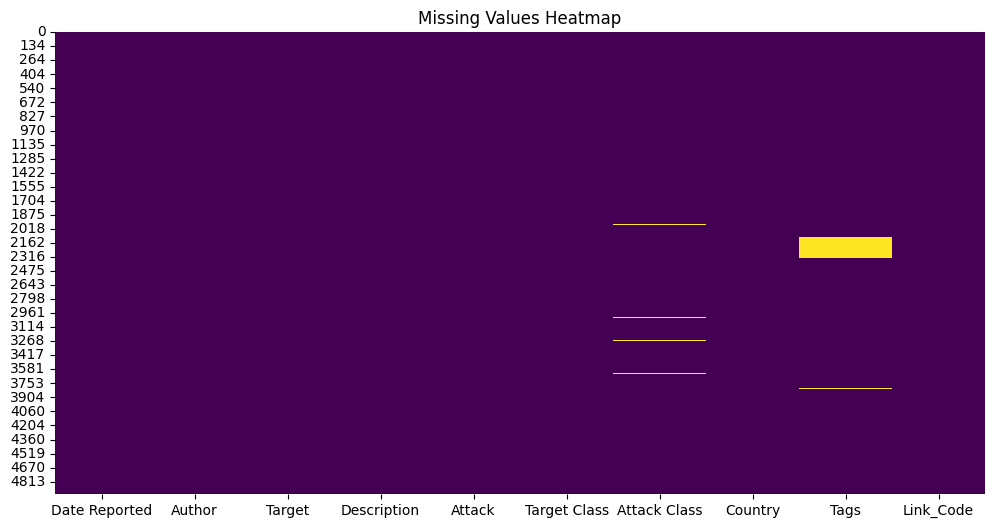

In [ ]:
# Total Missing Values per Column
print("\nMissing Values per Column:")
print(cleaned_data.isnull().sum())

# Percentage of Missing Values per Column
print("\nPercentage of Missing Values per Column:")
missing_percentage = cleaned_data.isnull().mean() * 100
print(missing_percentage)

# Visualize Missing Values (Requires Seaborn and Matplotlib)
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap to Show Missing Values
plt.figure(figsize=(12, 6))
sns.heatmap(cleaned_data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [ ]:
# Drop Rows with Any Missing Values
cleaned_data_dropped_rows = cleaned_data.dropna()

# Drop Columns with Any Missing Values
cleaned_data_dropped_cols = cleaned_data.dropna(axis=1)


In [ ]:
# Select numerical columns
numerical_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns

# Check if there are numerical columns left
if numerical_columns.empty:
    print("No numerical columns available after dropping missing values.")
else:
    # Summary statistics for the remaining numerical columns
    print("Summary Statistics for Numerical Columns After Dropping Missing Values:")
    numerical_summary = cleaned_data[numerical_columns].describe()
    print(numerical_summary)


Summary Statistics for Numerical Columns After Dropping Missing Values:
            Author       Attack  Target Class      Country
count  4013.000000  4013.000000   4013.000000  4013.000000
mean    625.058809    14.976327     22.003239    65.219287
std     228.091979     7.532892     10.657906    55.763506
min       0.000000     0.000000      0.000000     0.000000
25%     508.000000    13.000000     14.000000     2.000000
50%     768.000000    17.000000     21.000000    59.000000
75%     768.000000    17.000000     28.000000   123.000000
max     770.000000    26.000000     39.000000   139.000000


# **Still Missing Values on Tags**

In [ ]:
# Inspect missing values in Attack and Tags
print("Missing Values in 'Attack':", cleaned_data['Attack'].isnull().sum())
print("Missing Values in 'Tags':", cleaned_data['Tags'].isnull().sum())

# Percentage of missing values in these columns
print("\nPercentage of Missing Values:")
print(cleaned_data[['Attack', 'Tags']].isnull().mean() * 100)


Missing Values in 'Attack': 0
Missing Values in 'Tags': 187

Percentage of Missing Values:
Attack    0.000000
Tags      4.659855
dtype: float64


# **We Drop the Rows**

In [ ]:
# Drop rows with missing values in 'Tags'
cleaned_data = cleaned_data.dropna(subset=['Tags'])

# Verify
print("Missing Values After Dropping Rows:", cleaned_data['Tags'].isnull().sum())


Missing Values After Dropping Rows: 0


# **Statistics Summary**

In [ ]:
# Select numerical columns
numerical_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns

# Check if there are numerical columns
if numerical_columns.empty:
    print("No numerical columns available in the dataset.")
else:
    # Summary statistics for numerical columns
    print("Summary Statistics for Numerical Columns:")
    numerical_summary = cleaned_data[numerical_columns].describe()
    print(numerical_summary)


Summary Statistics for Numerical Columns:
            Author       Attack  Target Class      Country
count  3826.000000  3826.000000   3826.000000  3826.000000
mean    624.674072    15.001307     21.875327    65.340826
std     228.355353     7.535450     10.626955    55.850799
min       0.000000     0.000000      0.000000     0.000000
25%     508.000000    13.000000     14.000000     2.000000
50%     768.000000    17.000000     21.000000    59.000000
75%     768.000000    17.000000     28.000000   123.000000
max     770.000000    26.000000     39.000000   139.000000


In [ ]:
# Identify columns with zero variance
zero_variance_columns = numerical_columns[cleaned_data[numerical_columns].nunique() <= 1]
print("\nColumns with Zero Variance:")
print(zero_variance_columns)



Columns with Zero Variance:
Index([], dtype='object')


# **Correlation Matrix for Numerical Variables**


Correlation Matrix:
                Author    Attack  Target Class   Country
Author        1.000000 -0.274134      0.065980  0.066295
Attack       -0.274134  1.000000      0.018699 -0.157328
Target Class  0.065980  0.018699      1.000000 -0.213206
Country       0.066295 -0.157328     -0.213206  1.000000


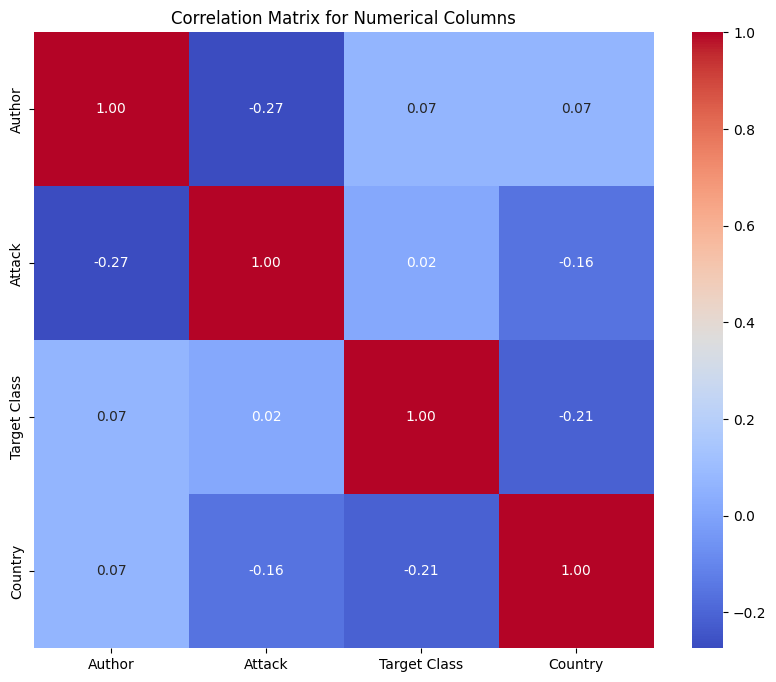

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = cleaned_data[numerical_columns].corr()
print(correlation_matrix)

# Heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Numerical Columns")
plt.show()


# **Outliers Detection (IQR)**

In [ ]:
# Detect potential outliers using IQR
print("\nPotential Outliers in Numerical Columns:")
for col in numerical_columns:
    q1 = cleaned_data[col].quantile(0.25)
    q3 = cleaned_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = cleaned_data[(cleaned_data[col] < lower_bound) | (cleaned_data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} potential outliers")



Potential Outliers in Numerical Columns:
Author: 188 potential outliers
Attack: 1466 potential outliers
Target Class: 0 potential outliers
Country: 0 potential outliers


# **Counting Frequencies and Proportions**

In [ ]:
# Columns to analyze (including Date Reported and Link Code)
columns_to_analyze = ['Author', 'Attack', 'Target Class', 'Country', 'Date Reported', 'Link_Code']

for col in columns_to_analyze:
    print(f"\nFrequencies and Proportions for '{col}':")

    # Frequency counts
    freq = cleaned_data[col].value_counts()
    print("\nFrequency Counts:")
    print(freq)

    # Proportions
    proportions = cleaned_data[col].value_counts(normalize=True) * 100
    print("\nProportions (%):")
    print(proportions)



Frequencies and Proportions for 'Author':

Frequency Counts:
Author
768    2442
515      42
162      38
155      31
403      30
       ... 
37        1
100       1
655       1
20        1
273       1
Name: count, Length: 749, dtype: int64

Proportions (%):
Author
768    63.826451
515     1.097752
162     0.993204
155     0.810246
403     0.784109
         ...    
37      0.026137
100     0.026137
655     0.026137
20      0.026137
273     0.026137
Name: proportion, Length: 749, dtype: float64

Frequencies and Proportions for 'Attack':

Frequency Counts:
Attack
17    1843
25     360
24     347
2      327
1      325
18      94
7       90
13      80
10      50
14      48
4       42
19      38
8       29
26      23
11      17
21      15
0       14
5       13
3       12
16      12
12      11
22      11
9       11
20       4
23       4
15       3
6        3
Name: count, dtype: int64

Proportions (%):
Attack
17    48.170413
25     9.409305
24     9.069524
2      8.546785
1      8.494511
18   

# **Visualizations of Frequencies (Bar Plots)**

---



<ipython-input-27-b2e84021840e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette="viridis")


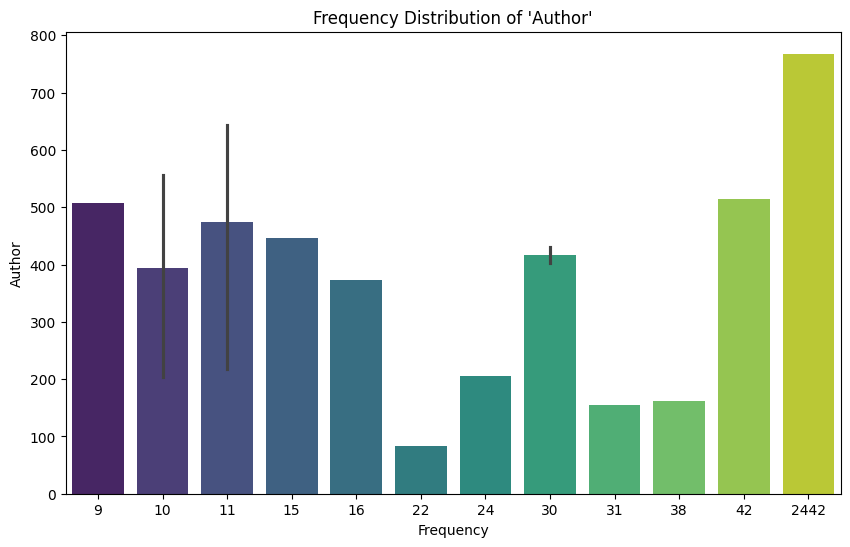

<ipython-input-27-b2e84021840e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette="viridis")


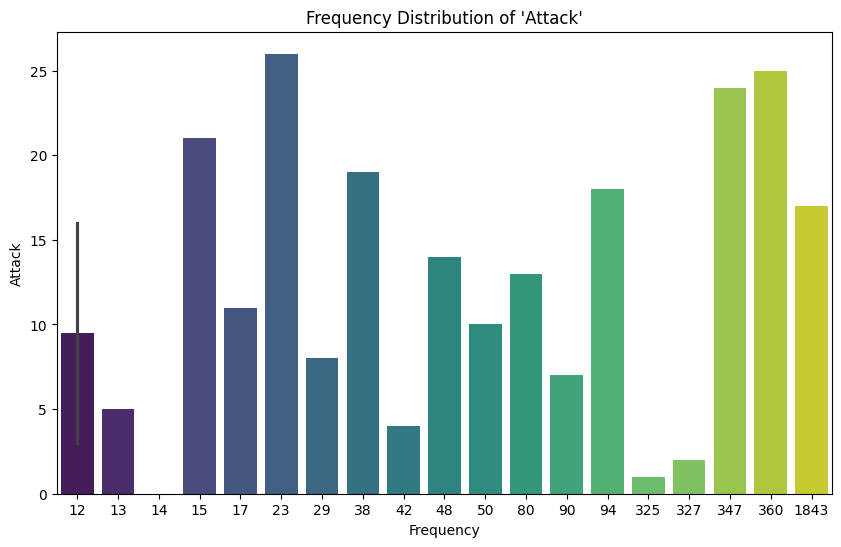

<ipython-input-27-b2e84021840e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette="viridis")


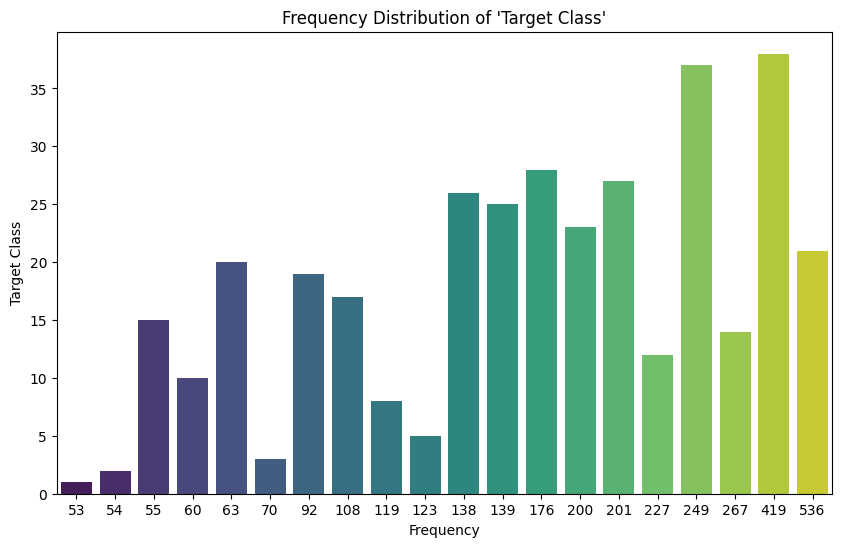

<ipython-input-27-b2e84021840e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette="viridis")


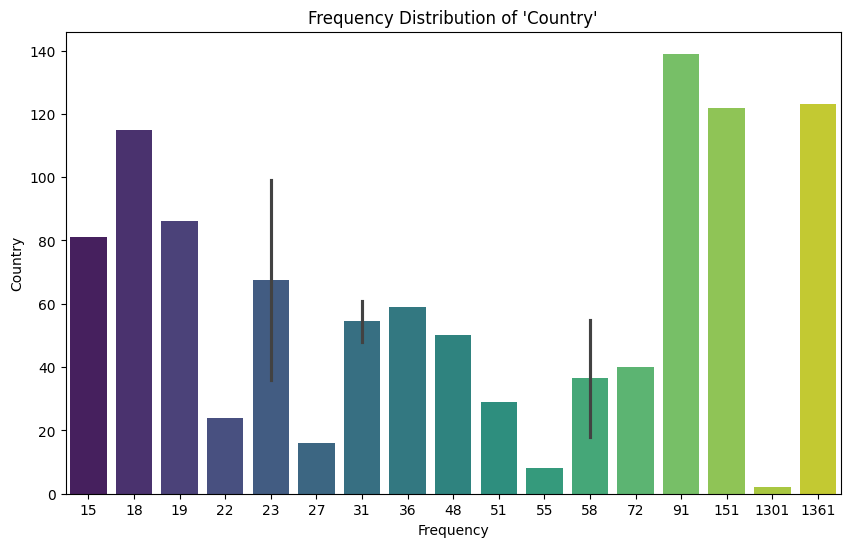

<ipython-input-27-b2e84021840e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette="viridis")


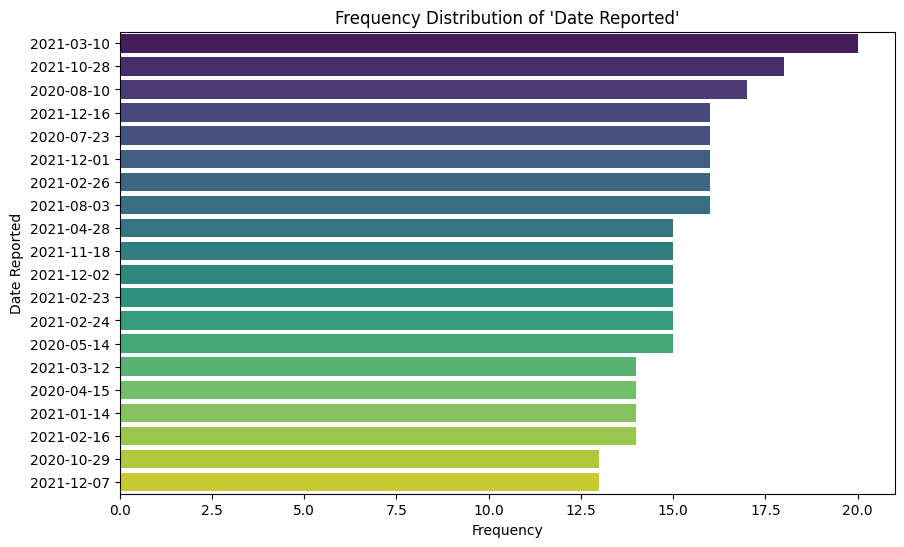

<ipython-input-27-b2e84021840e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette="viridis")


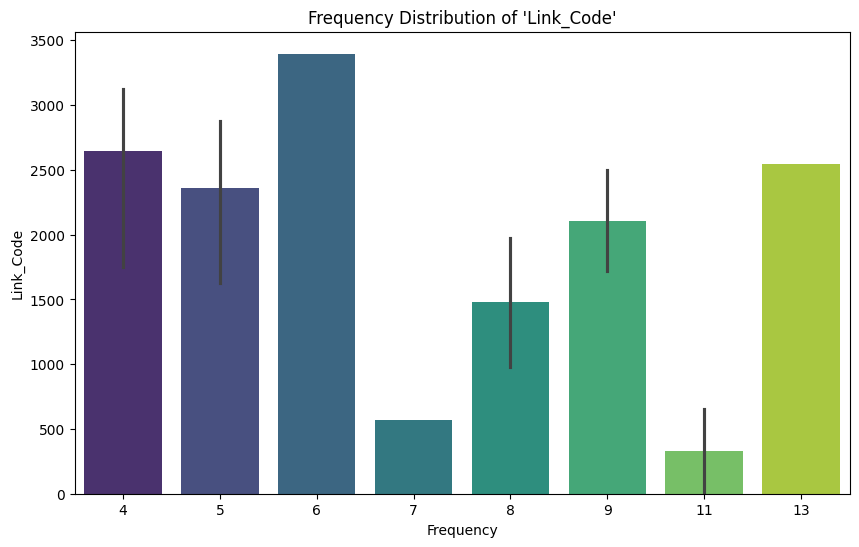

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in columns_to_analyze:
    plt.figure(figsize=(10, 6))
    freq = cleaned_data[col].value_counts().head(20)  # Display top 20 categories for readability
    sns.barplot(x=freq.values, y=freq.index, palette="viridis")
    plt.title(f"Frequency Distribution of '{col}'")
    plt.xlabel("Frequency")
    plt.ylabel(col)
    plt.show()


# **Pie Charts**

<ipython-input-28-b148e0e7bdab>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Use the 'tab20' colormap for distinct colors


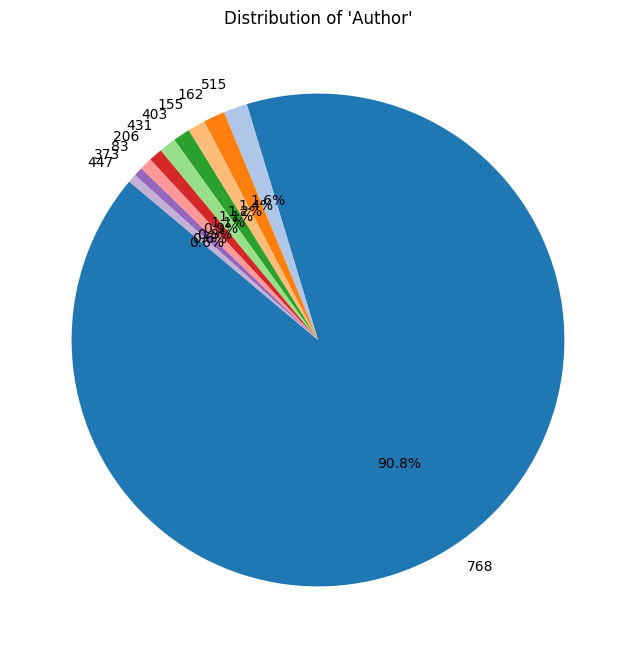

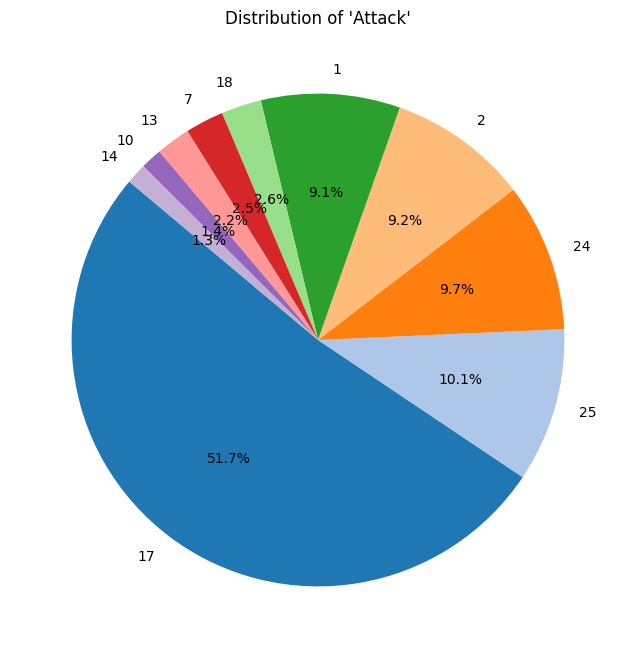

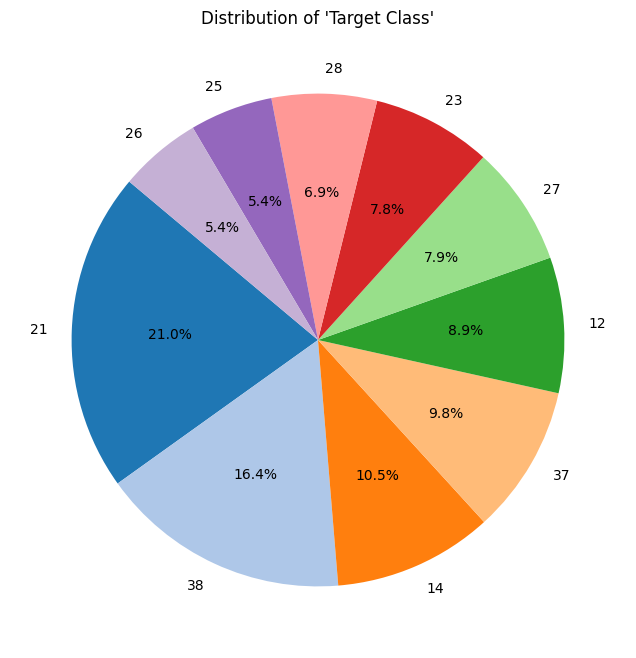

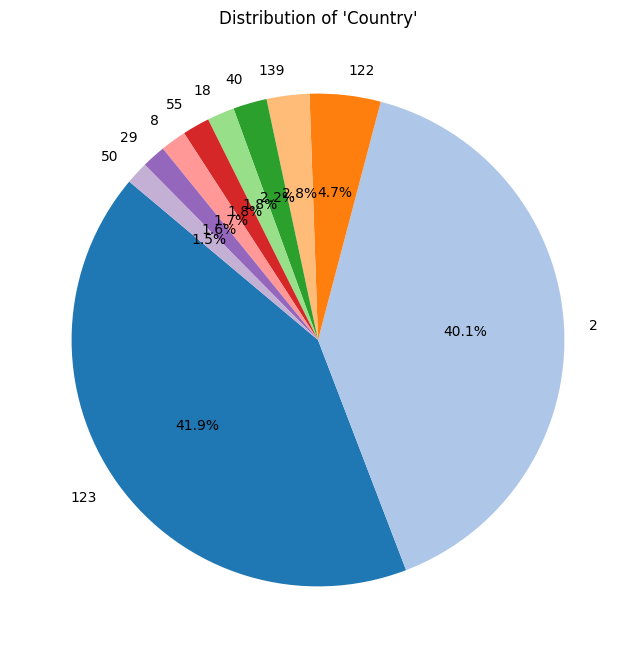

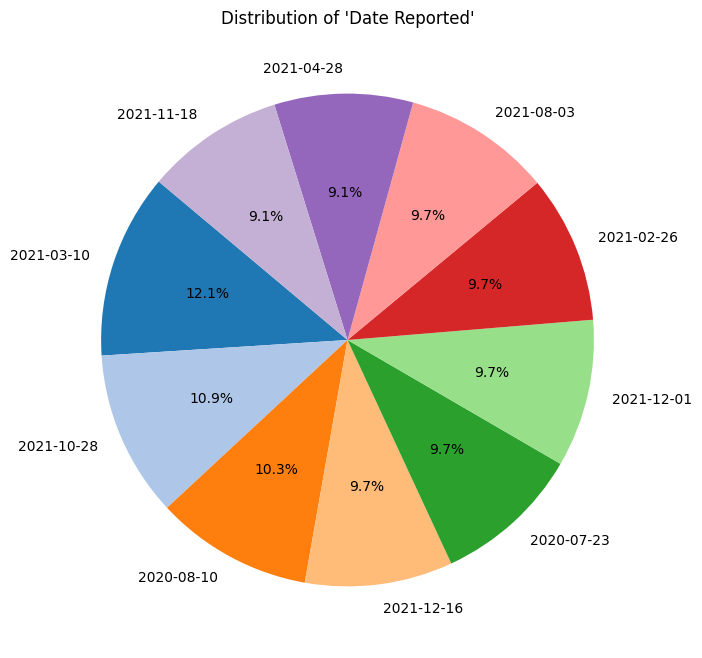

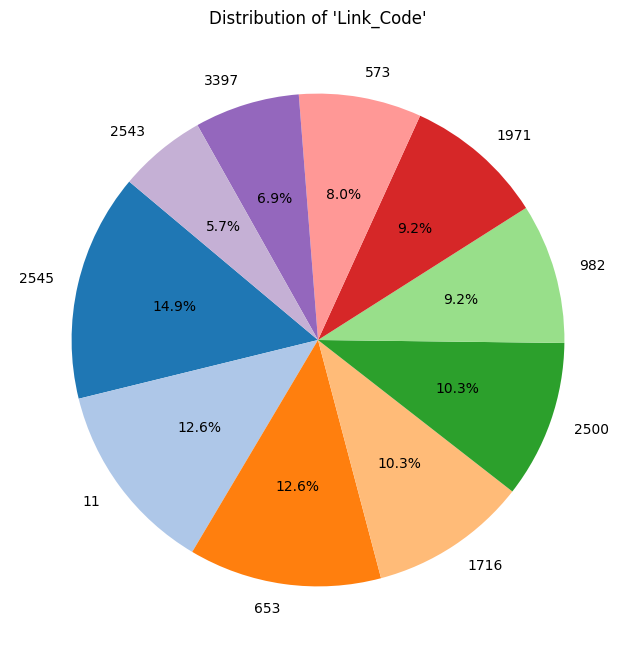

In [ ]:
import matplotlib.pyplot as plt

# Define distinct colors
from matplotlib.cm import get_cmap
cmap = get_cmap('tab20')  # Use the 'tab20' colormap for distinct colors

# Columns to plot
columns_to_plot = ['Author', 'Attack', 'Target Class', 'Country', 'Date Reported', 'Link_Code']

for col in columns_to_plot:
    plt.figure(figsize=(8, 8))
    freq = cleaned_data[col].value_counts().head(10)  # Top 10 categories for readability
    colors = cmap(range(len(freq)))  # Generate distinct colors for the categories
    plt.pie(freq.values, labels=freq.index, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f"Distribution of '{col}'")
    plt.show()


# **Measures of Central Tendency and Variability**

In [ ]:
# Select numerical columns
numerical_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns

# Compute measures for each numerical column
for col in numerical_columns:
    print(f"\nMeasures for '{col}':")

    # Central Tendency
    mean = cleaned_data[col].mean()
    median = cleaned_data[col].median()
    mode = cleaned_data[col].mode()[0]  # First mode if multiple modes exist

    print(f"  Mean: {mean}")
    print(f"  Median: {median}")
    print(f"  Mode: {mode}")

    # Variability
    variance = cleaned_data[col].var()
    std_dev = cleaned_data[col].std()
    value_range = cleaned_data[col].max() - cleaned_data[col].min()

    # Interquartile Range (IQR)
    q1 = cleaned_data[col].quantile(0.25)
    q3 = cleaned_data[col].quantile(0.75)
    iqr = q3 - q1

    print(f"  Variance: {variance}")
    print(f"  Standard Deviation: {std_dev}")
    print(f"  Range: {value_range}")
    print(f"  IQR: {iqr}")



Measures for 'Author':
  Mean: 624.6740721380031
  Median: 768.0
  Mode: 768
  Variance: 52146.167468748215
  Standard Deviation: 228.3553534926392
  Range: 770
  IQR: 260.0

Measures for 'Attack':
  Mean: 15.001306847882907
  Median: 17.0
  Mode: 17
  Variance: 56.78300482764958
  Standard Deviation: 7.535449875597978
  Range: 26
  IQR: 4.0

Measures for 'Target Class':
  Mean: 21.875326711970725
  Median: 21.0
  Mode: 21
  Variance: 112.9321649259038
  Standard Deviation: 10.62695464024872
  Range: 39
  IQR: 14.0

Measures for 'Country':
  Mean: 65.340825927862
  Median: 59.0
  Mode: 123
  Variance: 3119.311781173891
  Standard Deviation: 55.850799288585755
  Range: 139
  IQR: 121.0


# **Visualizing Distributions**

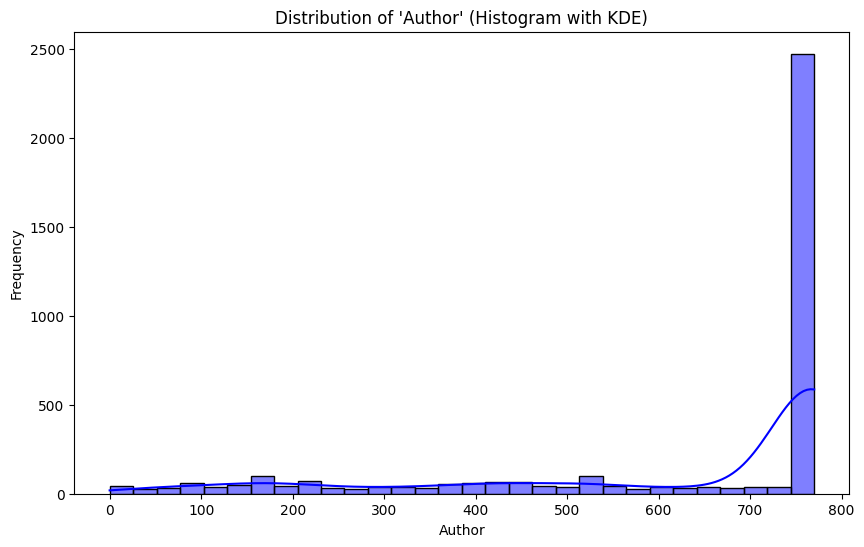

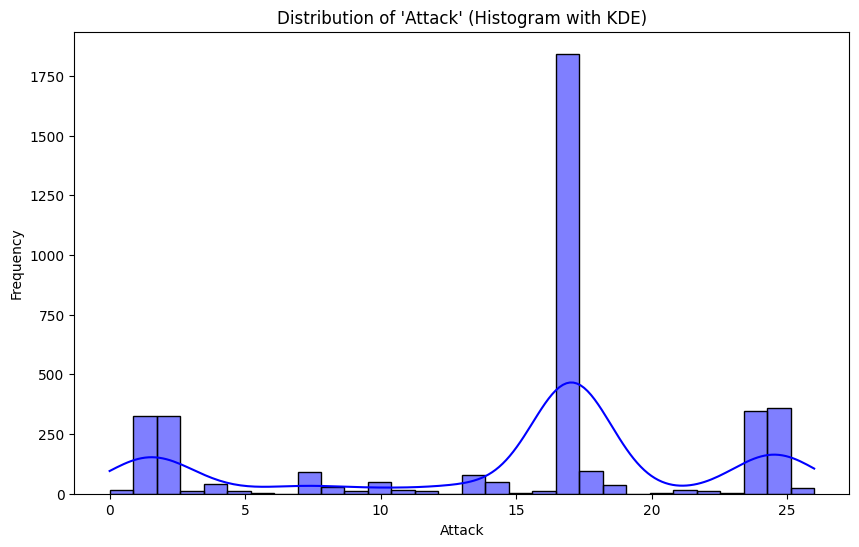

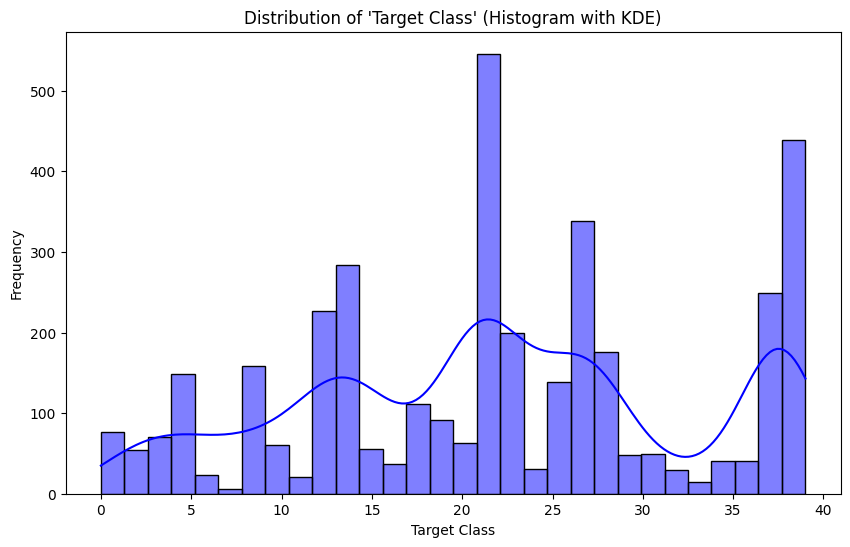

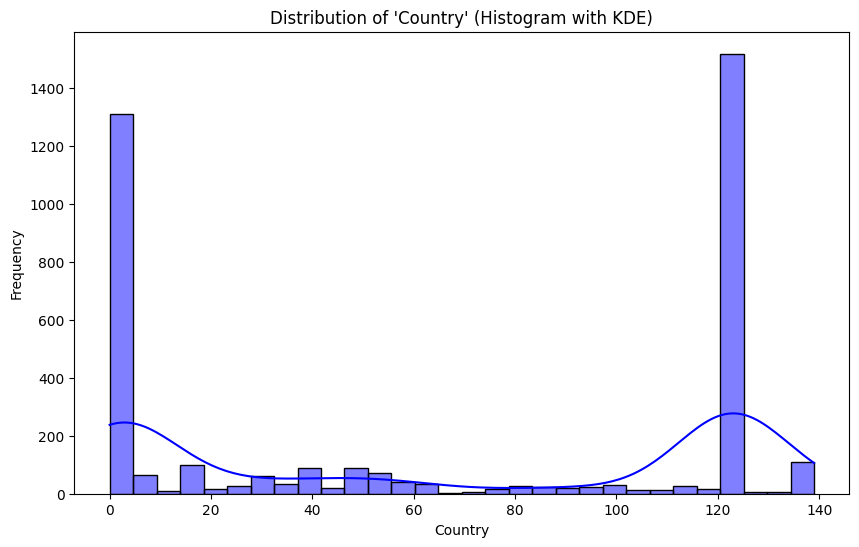

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
numerical_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(cleaned_data[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of '{col}' (Histogram with KDE)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


# **Box Plots**

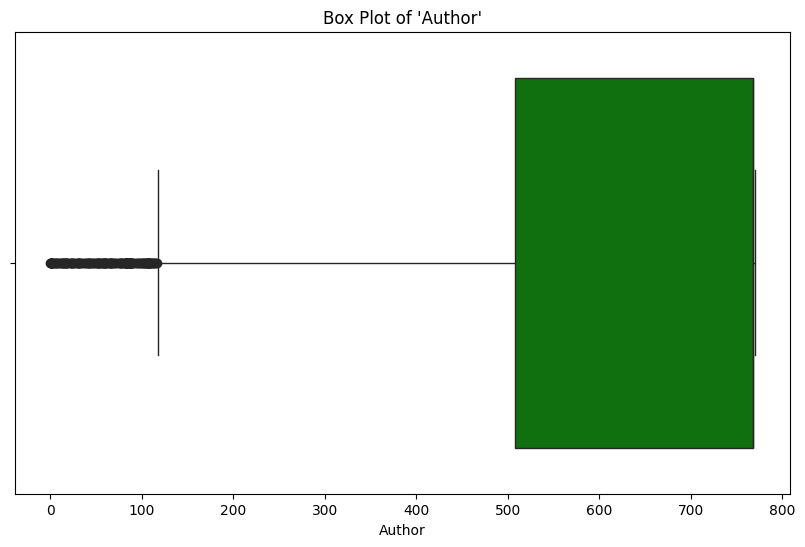

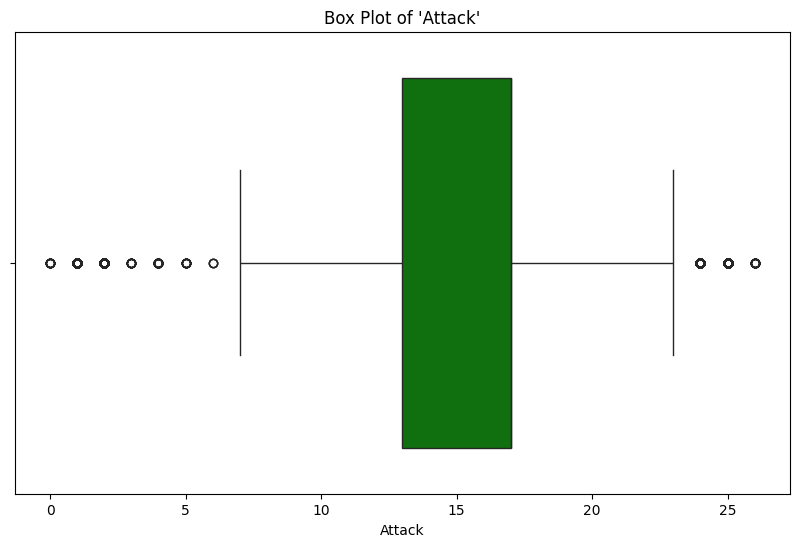

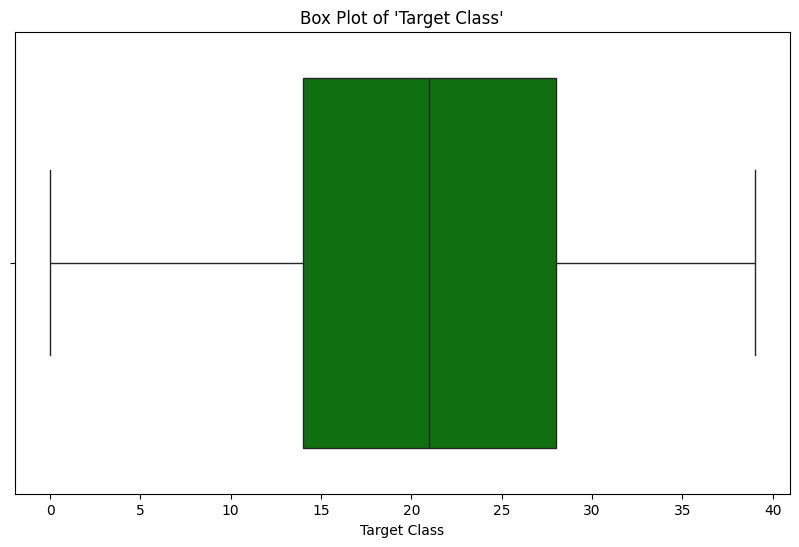

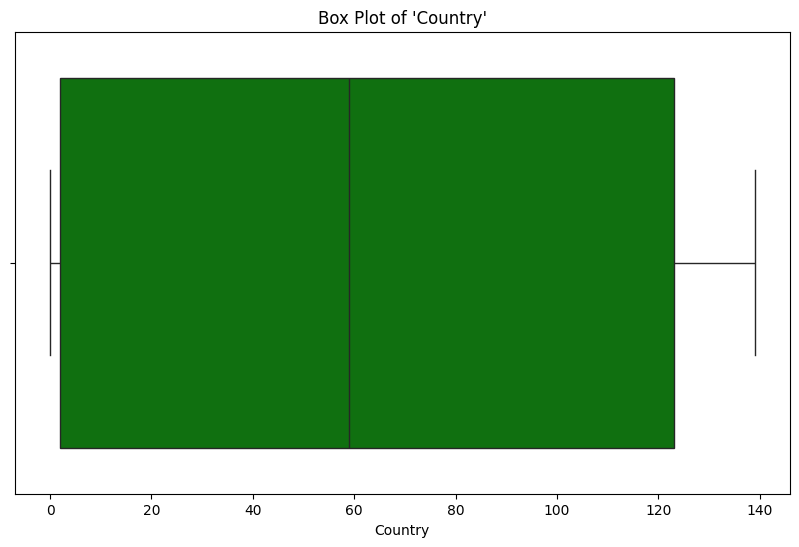

In [ ]:
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cleaned_data[col], color='green')
    plt.title(f"Box Plot of '{col}'")
    plt.xlabel(col)
    plt.show()


In [ ]:
import scipy.stats as stats

# Columns to analyze
numerical_columns = ['Author', 'Attack', 'Target Class', 'Country']

# Perform ANOVA for each pair of numerical columns
for col1 in numerical_columns:
    for col2 in numerical_columns:
        if col1 != col2:  # Avoid comparing a column with itself
            # Group the data by the first column
            groups = [group[col2].dropna() for name, group in cleaned_data.groupby(col1)]

            # Perform one-way ANOVA
            anova_result = stats.f_oneway(*groups)

            # Display results
            print(f"\nANOVA Results for '{col2}' by '{col1}':")
            print(f"  F-statistic: {anova_result.statistic}")
            print(f"  p-value: {anova_result.pvalue}")

            # Interpretation
            if anova_result.pvalue < 0.05:
                print("  Conclusion: Significant differences exist between the groups (p < 0.05).")
            else:
                print("  Conclusion: No significant differences between the groups (p >= 0.05).")



ANOVA Results for 'Attack' by 'Author':
  F-statistic: 1.471138498016207
  p-value: 1.6502237104293738e-12
  Conclusion: Significant differences exist between the groups (p < 0.05).

ANOVA Results for 'Target Class' by 'Author':
  F-statistic: 0.9152532509070226
  p-value: 0.9345070287979245
  Conclusion: No significant differences between the groups (p >= 0.05).

ANOVA Results for 'Country' by 'Author':
  F-statistic: 1.3174482563387584
  p-value: 4.211927257087893e-07
  Conclusion: Significant differences exist between the groups (p < 0.05).

ANOVA Results for 'Author' by 'Attack':
  F-statistic: 24.100043160026342
  p-value: 3.6961526192548246e-106
  Conclusion: Significant differences exist between the groups (p < 0.05).

ANOVA Results for 'Target Class' by 'Attack':
  F-statistic: 21.902462584756805
  p-value: 7.2233086474169335e-96
  Conclusion: Significant differences exist between the groups (p < 0.05).

ANOVA Results for 'Country' by 'Attack':
  F-statistic: 10.21564068732753

# **Clustering (KMeans) with PCA (Author, Attack, Target Class and Country Reduced to 2 Principal Components)**





Escalado de los datos y PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Definir las columnas a usar para clustering
columns_to_use = ['Attack', 'Author', 'Target Class', 'Country']  # Asegúrate de que estas columnas existen en cleaned_data
data_to_cluster = cleaned_data[columns_to_use]

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)

# Reducir dimensionalidad con PCA
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(scaled_data)

# Aplicar KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

#


Gráfico

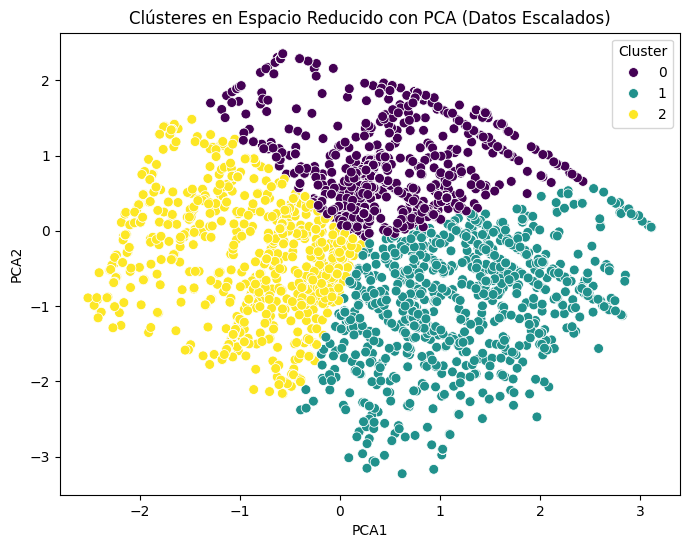

Varianza explicada por PCA1: 0.34
Varianza explicada por PCA2: 0.29


In [ ]:
# Crear DataFrame para graficar
df_pca = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = clusters

# Graficar
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=50)
plt.title('Clústeres en Espacio Reducido con PCA (Datos Escalados)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# Explicación de la varianza explicada
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por PCA1: {explained_variance[0]:.2f}")
print(f"Varianza explicada por PCA2: {explained_variance[1]:.2f}")


Elbow Method

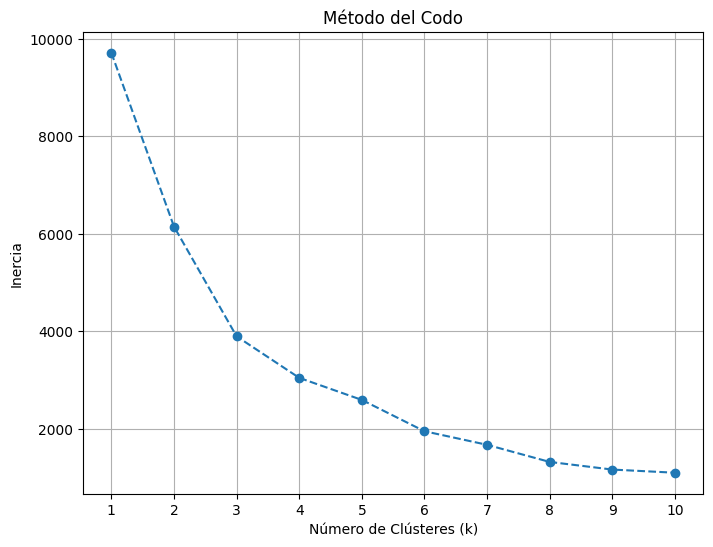

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para almacenar las inercia (distancia promedio al centroide)
inertia = []

# Probar diferentes números de clústeres
for k in range(1, 11):  # Puedes ajustar el rango (por ejemplo, hasta 15)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)  # Usamos los datos reducidos con PCA
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


# **Regresión Lineal (El Modelo no es Bueno debido al Label Encoding)**


Regresión Lineal: Author ~ Attack
  Coeficiente (Pendiente): -8.31
  Intercepto: 749.30
  Mean Squared Error (MSE): 48214.80
  R^2 Score: 0.08


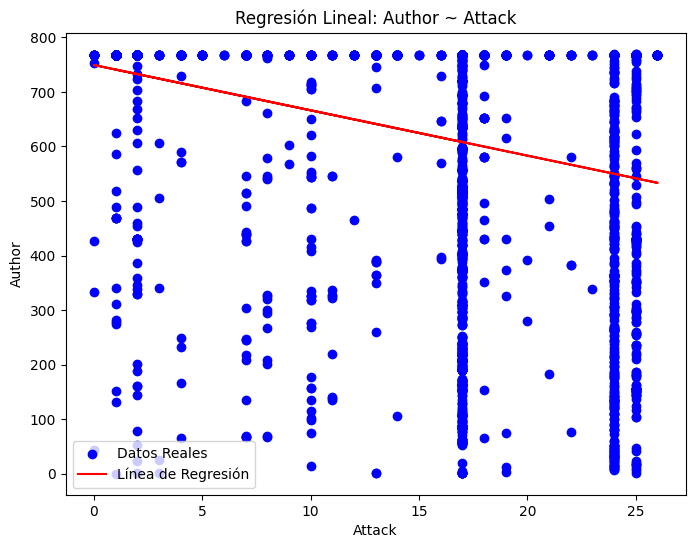


Regresión Lineal: Target Class ~ Author
  Coeficiente (Pendiente): 0.00
  Intercepto: 19.96
  Mean Squared Error (MSE): 112.41
  R^2 Score: 0.00


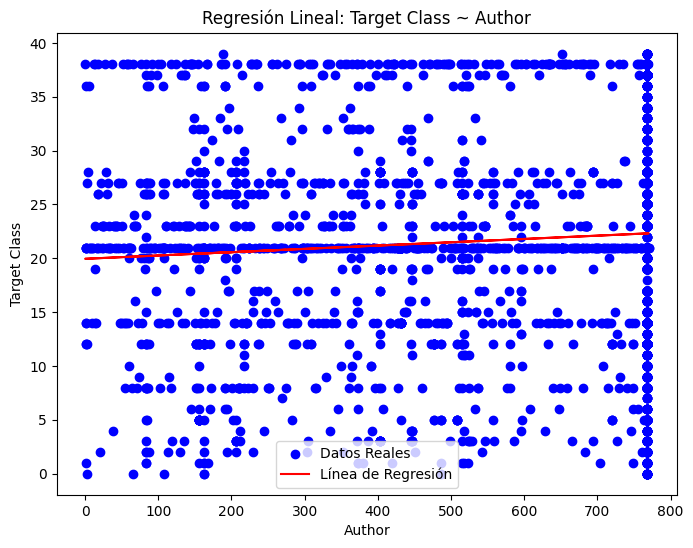


Regresión Lineal: Attack ~ Target Class
  Coeficiente (Pendiente): 0.01
  Intercepto: 14.71
  Mean Squared Error (MSE): 56.75
  R^2 Score: 0.00


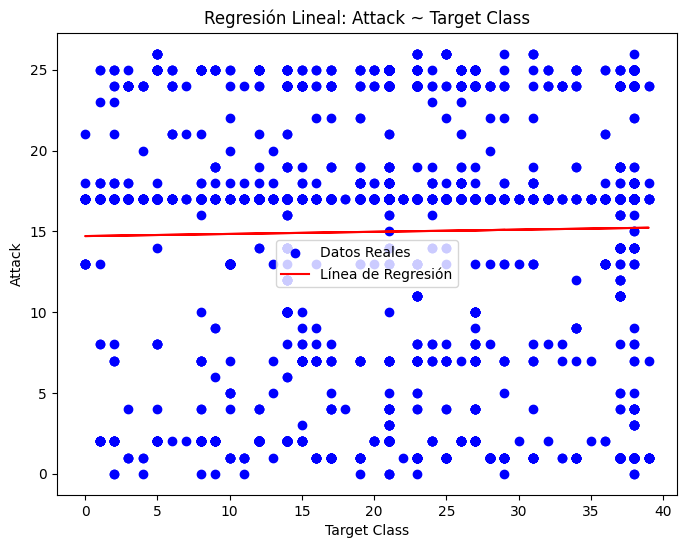

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Definir las parejas de variables (independiente, dependiente)
variable_pairs = [
    ('Attack', 'Author'),
    ('Author', 'Target Class'),
    ('Target Class', 'Attack')
]

# Iterar por cada pareja de variables
for independent_var, dependent_var in variable_pairs:
    print(f"\nRegresión Lineal: {dependent_var} ~ {independent_var}")

    # Seleccionar las variables de la pareja
    X = cleaned_data[[independent_var]].values  # Variable independiente
    y = cleaned_data[dependent_var].values  # Variable dependiente

    # Crear y ajustar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)

    # Predicciones
    y_pred = model.predict(X)

    # Métricas del modelo
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"  Coeficiente (Pendiente): {model.coef_[0]:.2f}")
    print(f"  Intercepto: {model.intercept_:.2f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  R^2 Score: {r2:.2f}")

    # Graficar la regresión
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, color='blue', label='Datos Reales')
    plt.plot(X, y_pred, color='red', label='Línea de Regresión')
    plt.title(f'Regresión Lineal: {dependent_var} ~ {independent_var}')
    plt.xlabel(independent_var)
    plt.ylabel(dependent_var)
    plt.legend()
    plt.show()
